### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import sys
from multiprocessing import cpu_count
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.externals import joblib

# Note: The xgboost package uses an older version of sklearn. 
# When you run "from xgboost.sklearn import XGBClassifier,"
# a DeprecationWarning is raised. You can ignore the warning.

from xgboost.sklearn import XGBClassifier

# Modify notebook settings
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create paths to data folders and files

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save the path to the folder that will contain the final,
# processed data: /data/processed
processed_data_dir = os.path.join(proj_root,
                                "data",
                                "processed")

# Save the path to final, processed Instacart data file.
final_csv_name = 'instacart_final.csv'

final_csv_path = os.path.join(processed_data_dir,
                              final_csv_name)

# Save path to the `models` folder, where we will save the
# pickled pipeline and grid search objects
models_folder = os.path.join(proj_root,
                             "models")

# Save the path to the folder that will contain the figures
# for the final report: /reports/figures
figures_dir = os.path.join(proj_root, "reports", "figures")

### Read in data

In [3]:
df = pd.read_csv(final_csv_path, index_col=0)

`total_buy_ratio_n5` is a linear combination of `total_buy_n5`. Therefore, we drop `total_buy_ratio_n5` from our feature set.

In [4]:
df = df.drop('total_buy_ratio_n5', axis=1)

### Prepare the train set and test set

In [5]:
# Extract X and y from df
X = df.drop('y', axis=1).values
y = df['y'].values

# Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Check the number of samples in each set.
print('{:,}'.format(len(y)))
print('{:,}'.format(len(y_train)))
print('{:,}'.format(len(y_test)))

13,307,953
9,315,567
3,992,386


## Create pipeline

In [7]:
# Create pipeline
pipe = Pipeline([('sampler', RandomUnderSampler()),
                 ('classifier', XGBClassifier())])

In [8]:
# Create parameter grid
param_grid = [
    {'classifier': [XGBClassifier(objective='binary:logistic')], 
     'sampler': [None, RandomUnderSampler(random_state=42)],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'classifier__gamma': [0.01],
     'classifier__max_delta_step': [0],
     'classifier__max_depth': [5],
     'classifier__subsample': [1],
     'classifier__reg_lambda': [1.0],
     'classifier__reg_alpha': [0.1]}]

In [9]:
# Set the number of cores to be used
cores_used = cpu_count() - 1
cores_used
cores_used = 1

In [10]:
# Set verbosity
verbosity = 1

# Execute Grid search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc',
                    verbose=verbosity, n_jobs=cores_used)

grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation ROC AUC score: {:.2f}".format(grid.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 25.1min finished


Best params:
{'classifier': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), 'classifier__gamma': 0.01, 'classifier__learning_rate': 0.1, 'classifier__max_delta_step': 0, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1.0, 'classifier__subsample': 1, 'sampler': None}

Best cross-validation ROC AUC score: 0.79


#### Save the grid search object as a pickle file

In [11]:
full_gridsearch_file_name = 'gridsearch_pickle.pkl'

full_gridsearch_path = os.path.join(models_folder,
                                    full_gridsearch_file_name)

joblib.dump(grid, full_gridsearch_path)

['../models/gridsearch_pickle.pkl']

In [12]:
best_pipeline_file_name = 'pipeline_pickle.pkl'

best_pipeline_path = os.path.join(models_folder, 
                                  best_pipeline_file_name)

joblib.dump(grid.best_estimator_, best_pipeline_path)

['../models/pipeline_pickle.pkl']

### Plot the Receiver Operating Characteristic Curve

In [13]:
clf = grid.best_estimator_

In [14]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                                    random_state=42)

dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

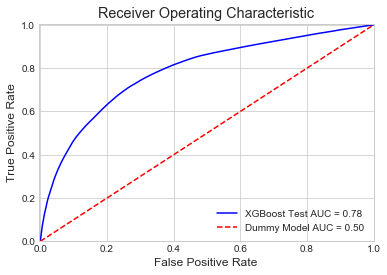

In [15]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(6,4))

probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, 'b', label = 'XGBoost Test AUC = %0.2f' % roc_auc)

probs = dummy_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, 'r--', label = 'Dummy Model AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.xlim([-0.005, 1])
plt.ylim([0, 1.005])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# figure file_name
fig_file_name = 'roc_curve'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300)